Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# 1. Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import lightgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor  
from sklearn.model_selection import GridSearchCV


import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

Отобразим базовую информацию о данных

In [2]:
df = pd.read_csv("/datasets/autos.csv")
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

Видим, что данные заполнены неоднородно, в некоторых колонках наблюдается значительное число пропусков, а также явно заметны несоответствующие данные. Например для колонки Power видим среднее значение 110, а максимальное 20000. Данные нуждаются в дополнительной предобработке. \
Отобразим численные данные в гистограммах

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f32b07f7a50>,
      dtype=object)

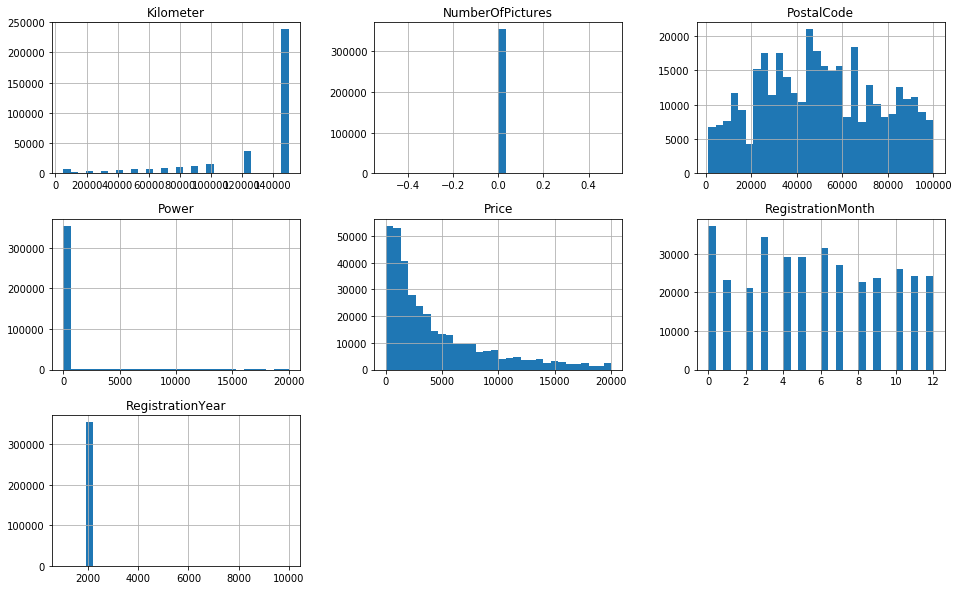

In [3]:
fig = plt.figure(figsize = (16, 10))
ax = fig.gca()
df.hist(figsize=(16,5), ax = ax, bins=30)

Хорошо видно несоответствие данных в колонках Power и RegistrationYear \
Возьмем срез по данным для колонки RegistrationYear

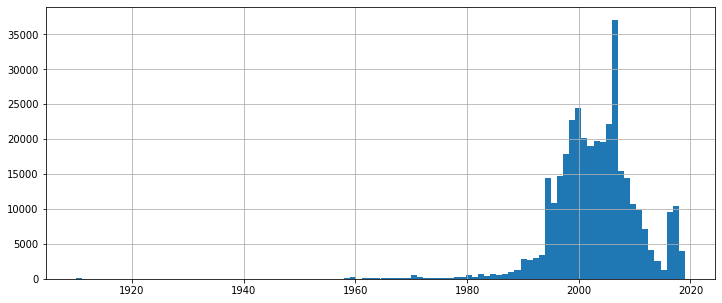

In [4]:
fig = plt.figure(figsize = (12,5))
ax = fig.gca()
df[(df["RegistrationYear"] > 1900) & (df["RegistrationYear"] < 2050)]["RegistrationYear"].hist(ax = ax, bins=100)

Видим, что в основном набор данных находится начиная с 1960 года. \
Возьмем аналогично для колонки Power \

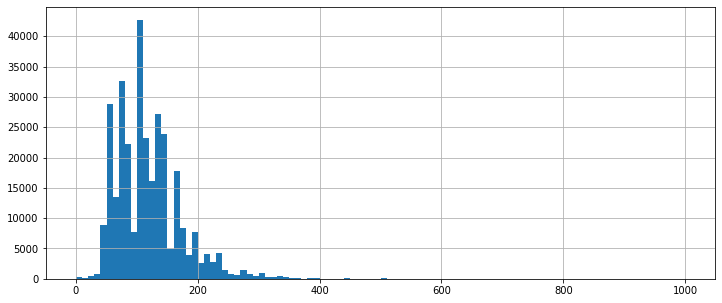

In [5]:
fig = plt.figure(figsize = (12,5))
ax = fig.gca()
df[(df["Power"] > 0) & (df["Power"] < 1000)]["Power"].hist(ax = ax, bins=100)

Видим, что в основном значения лежат в разрезе от 0 до 500.

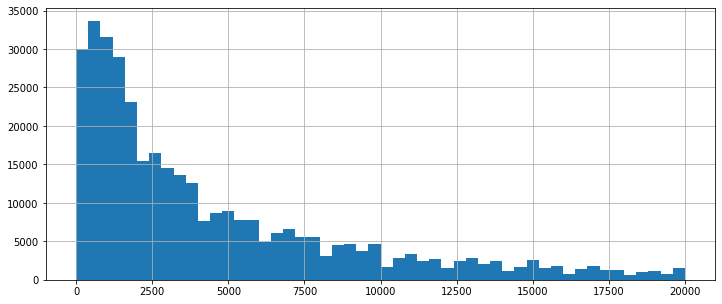

In [6]:
fig = plt.figure(figsize = (12,5))
ax = fig.gca()
df["Price"].hist(ax = ax, bins=50)

Срежем колонки, которые по логике не помогут нам в построении точных моделей \
DateCrawled - Дата сбора информации не влияет на качество модели\
NumberOfPictures - Нулевые значения во всех строках\
RegistrationMonth - Незначительные данные\
PostalCode - Колонка не влияющая на цену\
LastSeen - Колонка не влияющая на цену

In [7]:
df = df.ix[:,'Price':'NotRepaired'].drop(columns=['RegistrationMonth'])

Ограничим крайние значения в датафрейме, возьмем год начиная с 1960, Power с 30 до 500

In [8]:
df = df.query('RegistrationYear > 1960 and RegistrationYear < 2020 and Power < 500 and Power > 30  and Price > 50')
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,304758.0,4823.844171,4583.344361,55.0,1350.0,3150.0,6950.0,20000.0
RegistrationYear,304758.0,2003.377378,6.745616,1961.0,1999.0,2003.0,2008.0,2019.0
Power,304758.0,120.395652,53.051294,31.0,75.0,110.0,150.0,490.0
Kilometer,304758.0,128645.367800,36458.444138,5000.0,125000.0,150000.0,150000.0,150000.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 304758 entries, 1 to 354368
Data columns (total 10 columns):
Price               304758 non-null int64
VehicleType         283781 non-null object
RegistrationYear    304758 non-null int64
Gearbox             298876 non-null object
Power               304758 non-null int64
Model               292763 non-null object
Kilometer           304758 non-null int64
FuelType            285392 non-null object
Brand               304758 non-null object
NotRepaired         258358 non-null object
dtypes: int64(4), object(6)
memory usage: 25.6+ MB


None

Удалим оставшиеся нулевые данные, т.к. иначе нам не удастся построить модель.

In [9]:
df = df.dropna().reset_index(drop=True)
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
2,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
...,...,...,...,...,...,...,...,...,...,...
232222,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
232223,7900,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
232224,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
232225,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no


Проверим, все ли хорошо с нашими данными

In [10]:
display(df.describe().T)
display(df.info())

,count,mean,std,min,25%,50%,75%,max
Price,232227.0,5298.835243,4726.115588,55.0,1590.0,3699.0,7750.0,20000.0
RegistrationYear,232227.0,2003.140513,5.949206,1961.0,1999.0,2004.0,2007.0,2018.0
Power,232227.0,123.032063,53.085674,31.0,82.0,116.0,150.0,490.0
Kilometer,232227.0,127128.197841,36950.371647,5000.0,125000.0,150000.0,150000.0,150000.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232227 entries, 0 to 232226
Data columns (total 10 columns):
Price               232227 non-null int64
VehicleType         232227 non-null object
RegistrationYear    232227 non-null int64
Gearbox             232227 non-null object
Power               232227 non-null int64
Model               232227 non-null object
Kilometer           232227 non-null int64
FuelType            232227 non-null object
Brand               232227 non-null object
NotRepaired         232227 non-null object
dtypes: int64(4), object(6)
memory usage: 17.7+ MB


None

Обратим внимание на подозрительные значения колонки Kilometer. Выведем уникальные значения колонки

In [11]:
df["Kilometer"].unique()

array([150000,  90000,  70000, 100000,  60000,   5000,  20000, 125000,
        80000,  50000,  40000,  10000,  30000])

Т.к. в колонке лежат уникальные значения можем считать, что колонка категориальная.

Все вроде бы ок, однако категориальные значения необходимо заменить на численные. \
Воспользуемся LabelEncoder для преобразования

In [12]:
categorical_features = ["VehicleType","Gearbox", "Model", "Kilometer", "FuelType", "Brand", "NotRepaired"]
le = LabelEncoder()
df[categorical_features] = df[categorical_features].apply(lambda col: le.fit_transform(col))
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,1500,5,2001,1,75,116,12,6,37,0
1,3600,5,2008,1,69,101,9,2,31,0
2,650,4,1995,1,102,11,12,6,2,1
3,2200,1,2004,1,109,8,12,6,25,0
4,2000,4,2004,1,105,10,12,6,19,0
...,...,...,...,...,...,...,...,...,...,...
232222,1490,5,1998,1,50,143,12,6,37,0
232223,7900,4,2010,1,140,116,12,2,37,0
232224,3200,4,2004,1,225,140,12,6,30,1
232225,1199,1,2000,0,101,106,11,6,32,0


Все отлично, можно двигаться к обучению моделей.

# 2. Обучение моделей

Разделим выборку на тренировочную, тестовую и финальную и выделим целевой признак Price

In [13]:
target = df["Price"]
features = df.drop('Price', axis=1)

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.4, 
                                                                              random_state = 12345)

features_final, features_test, target_final, target_test = train_test_split(features_test, 
                                                                              target_test, 
                                                                              test_size=0.5, 
                                                                              random_state = 12345)

Выделим функцию отображения rmse для полученных предсказаний.

In [14]:
def print_rmse(target_predice, target_test):
    print(calculate_rmse(target_predice,target_test))

def calculate_rmse(target_predice, target_test):
    return mean_squared_error(target_predice,target_test) ** 0.5

### DecisionTreeRegressor

Для начала попробуем решить задачу с помощью DecisionTreeRegressor.  
Т.к. DecisionTreeRegressor выдает результат предсказания довольно быстро подберем такие параметры, которые приведут к наилучшему результату. Воспользуемся для этого GridSearchCV 

In [15]:
param_grid = {'max_depth': range(2,31,2),
              'min_samples_split': range(2,31,2)}

clf = GridSearchCV(DecisionTreeRegressor(), 
                   param_grid,
                   scoring='neg_mean_squared_error',
                   cv=5 , verbose=1)
clf.fit(features_train, target_train) 
clf.best_params_, clf.best_score_

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1125 out of 1125 | elapsed:  5.6min finished


({'max_depth': 26, 'min_samples_split': 30}, -3190480.8314427054)

Применим полученные гиперпараметры к модели.

In [16]:
dt_regressor = DecisionTreeRegressor(random_state = 12345, max_depth = 28, min_samples_split = 30)

Вычислим время обучения модели и предсказания

In [17]:
%%time
dt_regressor.fit(features_train, target_train)

CPU times: user 448 ms, sys: 0 ns, total: 448 ms
Wall time: 457 ms


DecisionTreeRegressor(criterion='mse', max_depth=28, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=30, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=12345, splitter='best')

In [18]:
%%time
y_pred_dt = dt_regressor.predict(features_test)
print_rmse(y_pred_dt, target_test)

1787.5725774452278
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 28.5 ms


Получим хорошую скорость предсказания модели и удовлетворительный rmse

### LightBM

Выделим метод генерации дерева lightgbm. \
Передадим методу три параметра: max_bin, learning_rate, num_boost_round и вернем сгенерированное дерево.

In [19]:
def generate_lgbm(max_bin, learning_rate, num_boost_round):
    train_data = lightgbm.Dataset(features_train, label=target_train, categorical_feature=categorical_features)
    test_data = lightgbm.Dataset(features_test, label=target_test, categorical_feature=categorical_features)
    parameters = {
        'application': 'regression',
        'metric': 'rmse',
        'boosting': 'gbdt',
        'z': max_bin,
        'learning_rate': learning_rate
    }
    model = lightgbm.train(parameters,
                           train_data,
                           num_boost_round=num_boost_round)
    return model


Воспользуемся подсказкой по тюнингу гиперпараметров с сайта посвященному lightgbm  (https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html) и подготовим три разные модели. \
Для первой постараемся подобрать гиперпараметры таким образом, чтобы она максимально быстро выдавала правильный ответ. \
Для второй подбираем параметры близкие к параметрам по умолчанию, так, чтобы она давай примерно средней по производительности и точности результат.  
Для последней постараемся найти гиперпараметры дающие максимально точные значения.

Описания гиперпараметров найдем здесь: https://lightgbm.readthedocs.io/en/latest/Parameters.html

#### Модель  1 (быстрый результат)

In [20]:
%%time
model1 = generate_lgbm(150, 0.3, 300) 

CPU times: user 10.6 s, sys: 116 ms, total: 10.7 s
Wall time: 10.9 s


In [21]:
%%time
print_rmse(model1.predict(features_test), target_test)

1523.9982096976312
CPU times: user 1.41 s, sys: 0 ns, total: 1.41 s
Wall time: 1.4 s


#### Модель 2 (сбалансированная)

In [22]:
%%time
model2 = generate_lgbm(255, 0.1, 1500)

CPU times: user 47.2 s, sys: 420 ms, total: 47.7 s
Wall time: 48.3 s


In [23]:
%%time
print_rmse(model2.predict(features_test), target_test)

1494.7940433903007
CPU times: user 8.79 s, sys: 0 ns, total: 8.79 s
Wall time: 8.98 s


#### Модель 3 (высокая точность)

In [24]:
%%time
model3 = generate_lgbm(400, 0.05, 2500)

CPU times: user 1min 20s, sys: 668 ms, total: 1min 21s
Wall time: 1min 22s


In [25]:
%%time
print_rmse(model3.predict(features_test), target_test)

1492.075935646243
CPU times: user 16.3 s, sys: 16 ms, total: 16.3 s
Wall time: 16.3 s


# 3. Анализ моделей

Как и ожидалось, первая модель хоть и показывает самую высокую оценку rmse, зато производит расчет крайне быстро. Обученную таким образом модель можно использовать для динамического прогнозирования цены пользователю, например, на специализированных сайтах или в мобильном приложении.

Вторая модель требует немного больше времени для расчетов, но предсказывает точнее (хоть и не столь значительно). Показывать результаты ее работы напрямую пользователю было бы не совсем корректно, неправильно заставлять пользователя ждать даже 10 секунд, однако модель с такой конфигурацией можно было бы применить во внутренних сервисах компании, для оценки стоимости автомобиля, там где не моментальный ответ допустим.


С третьей моделью мы вероятней всего столкнулись с проблемой переобучения. Rmse  ниже в рамках погрешности, а временные затраты для предсказания слишком велики. Использовать такую модель не представляется рациональным, лучше остановиться на первых двух. 

Основываясь на богатом наборе гиперпараметров lightgbm мы можем продолжать тестировать разные вариации для получение наилучшего результата. Например можно перебрать параметры num_leaves в сочетании с max_depth.

 #### Сравнения скорости и точности моделей LightBM и DecisionTreeRegressor

In [27]:
print_rmse(model1.predict(features_final), target_final)
print_rmse(model2.predict(features_final), target_final)
print_rmse(dt_regressor.predict(features_final), target_final)

1507.6968849595457
1477.1238801631168
1730.878001959136


In [28]:
%%time
model_pred = model1.predict(features_final)

CPU times: user 1.4 s, sys: 4 ms, total: 1.4 s
Wall time: 1.4 s


In [29]:
%%time
model2_pred = model2.predict(features_final)

CPU times: user 8.84 s, sys: 0 ns, total: 8.84 s
Wall time: 8.81 s


In [30]:
%%time
dt_pred = dt_regressor.predict(features_final)

CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 16 ms


|              	| rmse 	| evaluation time 	|
|:------------:	|:----:	|:---------------:	|
|    model1    	| 1507 	|      1.38 s     	|
|    model2    	| 1477 	|      8.6 s      	|
| dt_regressor 	| 1730 	|     16.5 ms     	|

С использованием lightgbm мы хоть и теряем в производительности модели, однако значительно приобретаем в ее точности. Необходимо отметить, что классические модели проще обучить и настроить, однако в реальной работе по всей видимости рационально использовать lightgbm с его богатством настроек.